Euler Scheme Option Price: 10.06839239861309
Milstein Scheme Option Price: 10.15601292526287


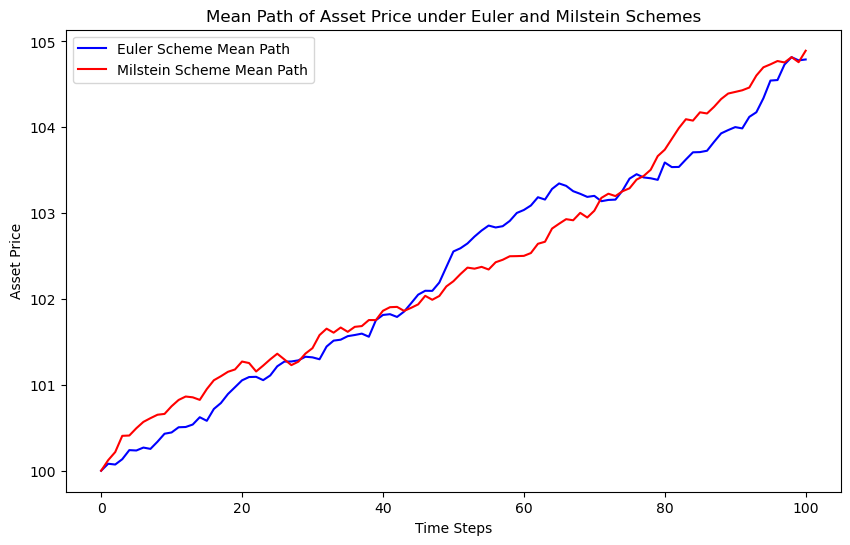

In [3]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt

# 初始化 Heston 模型的参数
S0 = 100       # 初始资产价格
v0 = 0.04      # 初始波动率
kappa = 2.0    # 均值回复速率
theta = 0.04   # 长期均值
sigma = 0.3    # 波动率的波动率
rho = -0.7     # 相关性
r = 0.05       # 无风险利率
T = 1          # 到期时间
K = 100        # 期权执行价格
num_paths = 1000   # 模拟路径数
num_steps = 100    # 时间步数
dt = T / num_steps

# 定义 Heston 模型下的 Euler 离散化方案
def euler_scheme(S, v, dt):
    Z1, Z2 = np.random.normal(size=2)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2
    v_next = v + kappa * (theta - v) * dt + sigma * np.sqrt(v) * np.sqrt(dt) * Z2
    v_next = max(v_next, 0)
    S_next = S * np.exp((r - 0.5 * v) * dt + np.sqrt(v) * np.sqrt(dt) * Z1)
    return S_next, v_next

# 定义 Heston 模型下的 Milstein 离散化方案
def milstein_scheme(S, v, dt):
    Z1, Z2 = np.random.normal(size=2)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2
    v_sqrt = np.sqrt(v)
    v_next = v + kappa * (theta - v) * dt + sigma * v_sqrt * np.sqrt(dt) * Z2 \
             + 0.25 * sigma**2 * dt * (Z2**2 - 1)
    v_next = max(v_next, 0)
    S_next = S * np.exp((r - 0.5 * v) * dt + v_sqrt * np.sqrt(dt) * Z1 \
                        + 0.5 * v_sqrt * sigma * dt * (Z1**2 - 1))
    return S_next, v_next

# 生成资产价格路径
def generate_paths(num_paths, num_steps, dt, scheme):
    S_paths = np.zeros((num_paths, num_steps + 1))
    v_paths = np.zeros((num_paths, num_steps + 1))
    S_paths[:, 0], v_paths[:, 0] = S0, v0
    for i in range(num_paths):
        S, v = S0, v0
        for j in range(1, num_steps + 1):
            S, v = scheme(S, v, dt)
            S_paths[i, j], v_paths[i, j] = S, v
    return S_paths, v_paths

# 定义期权收益函数
def call_option_payoff(S, K):
    return np.maximum(S - K, 0)

# 使用蒙特卡罗方法计算期权价格
def monte_carlo_price(S_paths, K, r, T):
    payoffs = call_option_payoff(S_paths[:, -1], K)
    discount_factor = np.exp(-r * T)
    return discount_factor * np.mean(payoffs)

# 计算并比较两种方案下的期权价格
S_paths_euler, _ = generate_paths(num_paths, num_steps, dt, euler_scheme)
S_paths_milstein, _ = generate_paths(num_paths, num_steps, dt, milstein_scheme)

euler_price = monte_carlo_price(S_paths_euler, K, r, T)
milstein_price = monte_carlo_price(S_paths_milstein, K, r, T)

print("Euler Scheme Option Price:", euler_price)
print("Milstein Scheme Option Price:", milstein_price)

# 可视化结果：绘制两种方案的均值路径
plt.figure(figsize=(10, 6))

# 计算每个时间步的均值
mean_path_euler = S_paths_euler.mean(axis=0)
mean_path_milstein = S_paths_milstein.mean(axis=0)

# 绘制均值路径
plt.plot(mean_path_euler, color="blue", label="Euler Scheme Mean Path")
plt.plot(mean_path_milstein, color="red", label="Milstein Scheme Mean Path")

# 图形标题和标签
plt.title("Mean Path of Asset Price under Euler and Milstein Schemes")
plt.xlabel("Time Steps")
plt.ylabel("Asset Price")
plt.legend()
plt.show()
